# Classification of Dialects using Spectral Moments and Formants

In [1]:
#Prerequisites
# Charalambos Themistocleous
# In this work I study the three main variants of PPA. So, I have excluded the non PPA variant. 
# Clean Memory before rerunning
for name in dir():
    if not name.startswith('_'): del globals()[name]
#dir()

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals


# libraries for dataset preparation, feature engineering, model training 
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve, classification_report

from keras import layers, models, optimizers
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras.layers import Dense, Dropout, GaussianNoise, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from scipy import interp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy, textblob, string, os

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def evaluate_from_history(history_model):
    """Charalambos Themistocleous 2018"""
    k =1
    accuracy = []
    sd_accuracy = []
    loss = []
    valid_accuracy = []
    sd_valid_accuracy = []
    valid_loss = []

    for i in history_model:
        model_hist = i
        accuracy.append(np.mean(model_hist.history['acc']))
        sd_accuracy.append(np.std(model_hist.history['acc']))
        loss.append(np.mean(model_hist.history['loss']))
        print(f"Epoch:{k}\n Accuracy: {np.mean(model_hist.history['acc'])}, Loss: {np.mean(model_hist.history['loss'])}")


        k = k+1
    print("======================================================================================")    
    print(f"\nTotal Results:\
    \nFinal Accuracy: {np.mean(accuracy)}\
    \nSD Accuracy: {np.std(accuracy)}\
    \nFinal Loss: {np.mean(loss)}")

In [4]:
# to make this notebook's output stable across runs


# To plot pretty figures
%matplotlib inline
plt.rcParams['legend.fontsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = 10, 10

# Where to save the figures
PROJECT_ROOT_DIR = "."
TITLE_ID = "speech_features"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "figures", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [5]:
# Import data
import pandas as pd
SEED = 2000
np.random.seed(SEED)

pd.options.display.max_columns = None

In [6]:
# Import Data

In [7]:
data = pd.read_csv("n.csv")

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (113) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data = data.loc[data["Segment"].isin(["l","n","r", "m"])]
data.head()
#data = data.drop(["phone"], axis=1)

,Unnamed: 0,AA,file,label,Duration,F1.5,F2.5,F3.5,F4.5,F5.5,F1.10,F2.10,F3.10,F4.10,F5.10,F1.15,F2.15,F3.15,F4.15,F5.15,F1.20,F2.20,F3.20,F4.20,F5.20,F1.25,F2.25,F3.25,F4.25,F5.25,F1.30,F2.30,F3.30,F4.30,F5.30,F1.35,F2.35,F3.35,F4.35,F5.35,F1.40,F2.40,F3.40,F4.40,F5.40,F1.45,F2.45,F3.45,F4.45,F5.45,F1.50,F2.50,F3.50,F4.50,F5.50,F1.55,F2.55,F3.55,F4.55,F5.55,F1.60,F2.60,F3.60,F4.60,F5.60,F1.65,F2.65,F3.65,F4.65,F5.65,F1.70,F2.70,F3.70,F4.70,F5.70,F1.75,F2.75,F3.75,F4.75,F5.75,F1.80,F2.80,F3.80,F4.80,F5.80,F1.85,F2.85,F3.85,F4.85,F5.85,F1.90,F2.90,F3.90,F4.90,F5.90,F1.95,F2.95,F3.95,F4.95,F5.95,X2,aa,file.1,label.1,duration,f0_min,f0_mean,f0_max,int_min,int_mean,int_max,F1,F2,F3,Keyword,Speaker,Variety,Segment,Selection,Position,Stress,VowelSelection
0,1,1,lasa1_02_03_2014_alexandra_1_217,l,0.103076,462.956029,1621.701238,2974.761385,3094.830543,3094.830543,495.715934,1738.396194,3105.424932,4102.091162,NaN,476.946532,1721.993020,3018.291800,3430.513395,4274.470088,464.298465,1711.277666,2859.388479,2975.642535,4274.028007,465.888169,1713.791759,2533.553015,3024.815894,4272.557677,465.792518,1690.790895,2404.457809,3071.747201,4276.784377,462.705218,1622.498840,2624.593068,3114.698680,4291.123784,461.201834,1592.197296,2805.323105,3138.116601,4290.963741,461.885488,1614.352209,2931.643285,3134.563016,4270.783176,462.956029,1621.701238,2974.761385,3094.830543,4261.099665,464.446184,1612.992047,2927.639871,3015.859040,4262.801087,465.793598,1602.131260,2925.502377,3089.826436,4224.420282,467.019120,1589.433152,2961.778285,3294.393620,4151.811887,467.978628,1570.319098,2969.607441,3412.190963,4120.996798,468.760110,1546.911232,2958.398870,3471.918384,4118.151498,469.257497,1524.327394,2928.732197,3490.929028,4181.240471,469.607721,1502.170414,2889.503994,3488.847867,4278.484230,480.119459,1502.393391,2916.670175,3518.438732,4181.025409,494.613594,1511.387292,2969.856967,3518.438732,4181.025409,7686,1,lasa1_02_03_2014_alexandra_1_217,l,103,153.0,157.0,158.0,52,54,54,488,1625,2861,lasa1,alexandra,SMG,l,l,Initial,Unstressed,FAIL
4,5,5,lasa1_02_03_2014_alexandra_1_40,l,0.120918,427.852869,1637.478983,3054.324594,3866.841883,3866.841883,466.235957,1708.842706,2787.986654,3496.769004,4233.974862,417.883289,1614.438037,2655.474679,3081.970766,4254.335211,419.587956,1467.360745,2792.753533,3082.082421,4303.155164,423.308499,1568.876704,2952.413799,3645.658050,4314.723531,426.907335,1725.571394,3100.521788,4251.231392,NaN,424.395910,1702.315190,3097.430207,3770.092615,4299.551898,423.932289,1686.859154,3091.191908,3711.089417,4299.551898,425.921323,1680.745382,3081.184784,4157.678096,NaN,427.852869,1637.478983,3054.324594,3866.841883,NaN,428.510430,1590.664010,3016.444402,3459.281084,4289.380423,421.858404,1576.813380,2938.912892,3437.406709,4286.702174,422.205991,1548.197452,2903.363860,3392.090635,4310.148274,429.752178,1504.396472,2910.990804,3322.666450,4360.461396,444.466312,1481.838442,2938.176676,3339.611474,4452.551261,459.659678,1472.347374,2962.360140,3447.431308,4534.141641,470.903181,1502.468016,2956.774790,3882.625612,NaN,515.801042,1558.149784,2974.837359,4225.616985,NaN,590.428065,1636.411416,3013.789728,4225.616985,NaN,7692,5,lasa1_02_03_2014_alexandra_1_40,l,121,181.0,206.0,223.0,53,55,57,465,1634,2998,lasa1,alexandra,SMG,l,l,Initial,Unstressed,FAIL
8,9,9,lasa1_02_03_2014_angeliki_205,l,0.077098,505.662297,1434.702965,2859.892959,3279.522116,3279.522116,475.838389,1692.049329,2957.239666,3513.631742,4510.469164,487.866658,1666.552160,2934.428764,3546.094373,4510.122349,497.011297,1653.942579,2916.275768,3554.068686,4502.490004,499.302237,1671.963725,2909.193506,3503.840100,4477.541690,501.593176,1689.984872,2902.111245,3453.611514,4452.593377,501.934050,1657.867181,2889.566193,3400.811307,4450.175571,501.447234,1604.468492,2874.702506,3346.919598,4457.320645,501.465827,1544.936348,2861.291900,3296.961707,4463.020682,505.662297,1434.702965,2859.892959,3279.522116,4456.775539,509.858768,1324.469582,2858.494018,3262.082524,445

In [9]:
data.shape

(2543, 122)

In [10]:
smdata = pd.read_csv("spectralmoments.csv")

In [11]:
smdata.head()

,Unnamed: 0,X.1,X,AA,file,Segment,duration,intensity,cog,sdev,skew,kurt,Speaker,keyword,Variety,Stress
0,1,1,1,1,λάσα_exp2_aliki_kontou_1_mono_24,l,119.890596,43.385975,611.950268,629.108530,17.201298,396.427305,alikikontou,lasa,CG,Stressed
1,2,2,2,2,λάσα_exp2_aliki_kontou_2_mono_176,l,90.639835,53.413668,811.575781,758.028018,9.377192,139.275050,alikikontou,lasa,CG,Stressed
2,3,3,3,3,λάσα_exp2_andri_athanasiou_mono_218,l,119.896107,55.893148,1015.390699,880.517781,3.306742,19.270265,andriathanasiou,lasa,CG,Stressed
3,4,4,4,4,λάσα_exp2_andri_athanasiou_mono_25,l,119.167025,56.423559,1045.030648,1020.526720,5.588071,54.850927,andriathanasiou,lasa,CG,Stressed
4,5,5,5,5,λάσα_exp2_andri_chatra_mono_222,l,58.836384,50.861743,953.242924,1015.228268,9.506986,136.939518,andrichatra,lasa,CG,Stressed


In [12]:
result =  pd.merge(data, smdata,  how='right', on=['file'])
# it seems that two rows are missing from the smdata and because we do not want to have missing information we exclude these by saying that get only the columsn that exist in smdata by selecting how is "left".



In [13]:
result.shape

(2541, 137)

In [14]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2541 entries, 0 to 2540
Columns: 137 entries, Unnamed: 0_x to Stress_y
dtypes: float64(105), int64(14), object(18)
memory usage: 2.7+ MB


In [15]:
for i in result.columns:
    print(i)

Unnamed: 0_x
AA_x
file
label
Duration
F1.5
F2.5
F3.5
F4.5
F5.5
F1.10
F2.10
F3.10
F4.10
F5.10
F1.15
F2.15
F3.15
F4.15
F5.15
F1.20
F2.20
F3.20
F4.20
F5.20
F1.25
F2.25
F3.25
F4.25
F5.25
F1.30
F2.30
F3.30
F4.30
F5.30
F1.35
F2.35
F3.35
F4.35
F5.35
F1.40
F2.40
F3.40
F4.40
F5.40
F1.45
F2.45
F3.45
F4.45
F5.45
F1.50
F2.50
F3.50
F4.50
F5.50
F1.55
F2.55
F3.55
F4.55
F5.55
F1.60
F2.60
F3.60
F4.60
F5.60
F1.65
F2.65
F3.65
F4.65
F5.65
F1.70
F2.70
F3.70
F4.70
F5.70
F1.75
F2.75
F3.75
F4.75
F5.75
F1.80
F2.80
F3.80
F4.80
F5.80
F1.85
F2.85
F3.85
F4.85
F5.85
F1.90
F2.90
F3.90
F4.90
F5.90
F1.95
F2.95
F3.95
F4.95
F5.95
X2
aa
file.1
label.1
duration_x
f0_min
f0_mean
f0_max
int_min
int_mean
int_max
F1
F2
F3
Keyword
Speaker_x
Variety_x
Segment_x
Selection
Position
Stress_x
VowelSelection
Unnamed: 0_y
X.1
X
AA_y
Segment_y
duration_y
intensity
cog
sdev
skew
kurt
Speaker_y
keyword
Variety_y
Stress_y


In [16]:
columns =  ['Speaker_x','label','Variety_x','duration_x', 'f0_mean', 'f0_min', 'f0_max',
            'F1.25', 'F1.50', 'F1.75', 'F2.25', 'F2.50', 
            'F2.75', 'F3.25', 'F3.50', 'F3.75', 'F4.25', 
            'F4.50', 'F4.75', 'F5.25', 'F5.50', 'F5.75', 'F1', 'F2', 'F3', 
            'intensity', 'cog', 'sdev', 'skew', 'kurt']
df = result[columns]

In [17]:
df.select_dtypes(include=['object']).copy()
set(df.label)

{'l', 'm', 'n', 'r'}

In [18]:
df.Variety_x.value_counts()

CG     1274
SMG    1267
Name: Variety_x, dtype: int64

In [19]:
cleanup_nums = {'Speaker_x': {'alexandra': 1,
                            'alikikontou': 2, 'andriathanasiou': 3, 'andrichatra': 4, 'andrichristophi': 5,
                            'andrilouka': 6, 'angelandriasavva': 7,
                            'angeliki': 8, 'annasp': 9, 'annaz': 10, 'anthoulakoupepia': 11, 'antonia': 12,
                            'aristodemouandri': 13,
                            'christianachristodoulou': 14, 'eleninikolaou': 15, 'elina': 16, 'emilialanitou': 17,
                            'frosw': 18,
                            'georgiaioannou': 19, 'giannachatziiosif': 20, 'giannaok': 21, 'govari': 22,
                            'irinichatzigiannakou': 23,
                            'iris': 25, 'isidora': 26, 'katerina': 27, 'katerinalar': 28, 'katerinamiltiadous': 29,
                            'mariaantioniou': 30,
                            'mariamavronikola': 31, 'maro': 32, 'rania': 33, 'stellaevangelou': 34, 'swtiria': 35,
                            'theodouloumaria': 36, 'vangelio': 37, 'vasia': 38, 'vasw': 39, 'venetia': 40,
                            'zoiparaskeva': 41},
                'Variety_x': {'CG': 0, 'SMG': 1},
                'label': {'l': 1, 'm': 2, 'n': 3, 'r': 0}
                }

In [20]:
df.replace(cleanup_nums, inplace=True)

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [21]:
#df = df.drop(["label"], axis=1)

In [22]:
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0) 
dfim=imp.fit_transform(df)
df = pd.DataFrame(dfim, columns=columns)

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [23]:
df.head()

,Speaker_x,label,Variety_x,duration_x,f0_mean,f0_min,f0_max,F1.25,F1.50,F1.75,F2.25,F2.50,F2.75,F3.25,F3.50,F3.75,F4.25,F4.50,F4.75,F5.25,F5.50,F5.75,F1,F2,F3,intensity,cog,sdev,skew,kurt
0,1.0,1.0,1.0,103.0,157.0,153.0,158.0,465.888169,462.956029,468.760110,1713.791759,1621.701238,1546.911232,2533.553015,2974.761385,2958.398870,3024.815894,3094.830543,3471.918384,4272.557677,4261.099665,4118.151498,488.0,1625.0,2861.0,52.518558,562.520784,611.117094,15.486228,353.600405
1,1.0,1.0,1.0,121.0,206.0,181.0,223.0,423.308499,427.852869,444.466312,1568.876704,1637.478983,1481.838442,2952.413799,3054.324594,2938.176676,3645.658050,3866.841883,3339.611474,4314.723531,4490.540204,4452.551261,465.0,1634.0,2998.0,51.749160,598.170833,786.696990,15.368919,301.086421
2,8.0,1.0,1.0,77.0,187.0,178.0,193.0,499.302237,505.662297,515.666975,1671.963725,1434.702965,1399.149396,2909.193506,2859.892959,2831.514448,3503.840100,3279.522116,3281.384777,4477.541690,4456.775539,4486.372904,512.0,1569.0,2903.0,53.880622,982.809824,990.016210,4.859954,51.454616
3,8.0,1.0,1.0,100.0,178.0,154.0,195.0,490.208999,501.579222,473.264110,1584.038962,1644.487800,1510.012008,2910.884257,2924.899450,3058.832535,3483.478310,3547.525956,3581.000567,4347.818708,4449.496132,4504.651564,500.0,1609.0,2959.0,53.296279,642.752035,602.996768,7.102754,101.190354
4,12.0,1.0,1.0,38.0,207.0,203.0,219.0,399.528330,372.680916,371.707667,1848.861258,1736.247539,1653.571383,3192.033705,3023.045400,2971.949826,4345.132515,3744.404348,3730.024872,4467.728041,4347.199317,4347.199317,405.0,1777.0,3149.0,38.469376,673.131001,824.983772,13.453678,240.581363


In [24]:
a=np.log(df)
a = a.drop(["Speaker_x"], axis=1)
corr_matrix=a.corr() 
corr_matrix['Variety_x'].sort_values(ascending=False)

/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


label        NaN
Variety_x    NaN
duration_x   NaN
f0_mean      NaN
f0_min       NaN
f0_max       NaN
F1.25        NaN
F1.50        NaN
F1.75        NaN
F2.25        NaN
F2.50        NaN
F2.75        NaN
F3.25        NaN
F3.50        NaN
F3.75        NaN
F4.25        NaN
F4.50        NaN
F4.75        NaN
F5.25        NaN
F5.50        NaN
F5.75        NaN
F1           NaN
F2           NaN
F3           NaN
intensity    NaN
cog          NaN
sdev         NaN
skew         NaN
kurt         NaN
Name: Variety_x, dtype: float64

In [25]:
# define 10-fold cross validation test harness

d = df
speaker = d.Speaker_x
d = d.drop(["Speaker_x"], axis=1)
y = d.Variety_x
d = d.drop(["label"], axis=1)
d = d.drop(["Variety_x"], axis=1)
X = d

In [26]:
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve
from scipy import interp
from keras.optimizers import SGD

group_kfold = GroupKFold(n_splits=3)
group_kfold.get_n_splits(X.values, y.values, speaker.values)
print(group_kfold) 
np.random.seed(SEED)

cRF_tprs = []
cRF_aucs = []
cSVM_tprs = []
cSVM_aucs = []
cDT_tprs = []
cDT_aucs = []
cSNN_tprs = []
cSNN_aucs = []


mean_fpr = np.linspace(0, 1, 100)
cRF_resultsA = []
cSVM_resultsA = []
cDT_resultsA = []
cSNN_resultsA = []

cRF_resultsB = []
cSVM_resultsB = []
cDT_resultsB = []
cSNN_resultsB = []

history = []
i = 0

epochs = 500
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)


# Define the neural network here
snn = Sequential()
snn.add(Dense(150, input_dim=27, activation='relu'))
snn.add(Dense(150, activation='relu'))   
snn.add(Dense(150, activation='relu'))
snn.add(Dense(150, activation='relu'))
snn.add(Dense(150, activation='relu'))   
snn.add(Dense(150, activation='relu'))
snn.add(Dense(150, activation='relu'))
snn.add(Dense(150, activation='relu'))
snn.add(Dense(1, kernel_initializer='random_normal', activation='sigmoid'))
snn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])



#logo.get_n_splits(groups=groups) # 'groups' is always required
for train_index, test_index in group_kfold.split(np.sqrt(X), y, speaker):
    X_train_folds, X_test_folds = X.iloc[train_index], X.iloc[test_index]
    y_train_folds, y_test_folds = y[train_index], y[test_index]
    scaler = preprocessing.MinMaxScaler().fit(X_train_folds)
    X_train_transformed = scaler.transform(X_train_folds)
    

    print("==========================================================================")
    print("FOLD {}".format(i))
    print("==========================================================================")
    #
    # Compile model
    cRF = RandomForestClassifier(n_estimators=512, max_depth=None, min_samples_split=2, random_state=30).fit(X_train_transformed, y_train_folds)
    cSVM = svm.SVC(C=3, kernel="linear").fit(X_train_transformed, y_train_folds)
    cDT = DecisionTreeClassifier(random_state=452).fit(X_train_transformed, y_train_folds)
    cSNN = snn.fit(X_train_transformed, y_train_folds, epochs=epochs, batch_size=15, verbose=True)
    history.append(cSNN)
    # Transform X_Test  
    X_test_transformed = scaler.transform(X_test_folds)

    # Evaluate classifiers
    cRF_y_pred = cRF.predict(X_test_transformed)
    cSVM_y_pred = cSVM.predict(X_test_transformed)
    cDT_y_pred = cDT.predict(X_test_transformed)
    cSNN_y_pred = snn.predict_classes(X_test_transformed)
    #print(cSNN_y_pred)

    # Corrects
    cRF_n_correct = sum(cRF_y_pred == y_test_folds)
    cSVM_n_correct = sum(cSVM_y_pred == y_test_folds)
    cDT_n_correct = sum(cDT_y_pred == y_test_folds)
    cSNN_n_correct = sum(cSNN_y_pred == y_test_folds.values)

    #
    cRF_accuracy1 = cRF_n_correct / len(cRF_y_pred)
    cSVM_accuracy1 = cSVM_n_correct / len(cSVM_y_pred)
    cDT_accuracy1 = cDT_n_correct / len(cDT_y_pred)
    cSNN_accuracy1 = cSNN_n_correct / len(cSNN_y_pred)

    #
    cRF_accuracy2 = cRF.score(X_test_transformed, y_test_folds)
    print(f"RF: {cRF_accuracy2}")
    cSVM_accuracy2 = cSVM.score(X_test_transformed, y_test_folds)
    print(f"SVM: {cSVM_accuracy2}")
    cDT_accuracy2 = cDT.score(X_test_transformed, y_test_folds)
    print(f"DT: {cDT_accuracy2}")
    cSNN_accuracy2 = snn.evaluate(X_test_transformed, y_test_folds, verbose=1)     
    print(f"SNN: {cSNN_accuracy2}")
    #
    cRF_resultsA.append(cRF_accuracy1)
    cSVM_resultsA.append(cSVM_accuracy1)
    cDT_resultsA.append(cDT_accuracy1)
    cSNN_resultsA.append(cSNN_accuracy1)

    #
    cRF_resultsB.append(cRF_accuracy2)
    cSVM_resultsB.append(cSVM_accuracy2)
    cDT_resultsB.append(cDT_accuracy2)
    cSNN_resultsB.append(cSNN_accuracy2)

    # Compute ROC curve and area the curve RF
    cRF_fpr, cRF_tpr, cRF_thresholds = roc_curve(y_test_folds, cRF_y_pred)
    cRF_tprs.append(interp(mean_fpr, cRF_fpr, cRF_tpr))
    cRF_tprs[-1][0] = 0.0
    cRF_roc_auc = auc(cRF_fpr, cRF_tpr)
    cRF_aucs.append(cRF_roc_auc)

    # Compute ROC curve and area the curve SVM
    cSVM_fpr, cSVM_tpr, cSVM_thresholds = roc_curve(y_test_folds, cSVM_y_pred)
    cSVM_tprs.append(interp(mean_fpr, cSVM_fpr, cSVM_tpr))
    cSVM_tprs[-1][0] = 0.0
    cSVM_roc_auc = auc(cSVM_fpr, cSVM_tpr)
    cSVM_aucs.append(cSVM_roc_auc)

    # Compute ROC curve and area the curve
    cDT_fpr, cDT_tpr, cDT_thresholds = roc_curve(y_test_folds, cDT_y_pred)
    cDT_tprs.append(interp(mean_fpr, cDT_fpr, cDT_tpr))
    cDT_tprs[-1][0] = 0.0
    cDT_roc_auc = auc(cDT_fpr, cDT_tpr)
    cDT_aucs.append(cDT_roc_auc)

        # Compute ROC curve and area the curve RF
    cSNN_fpr, cSNN_tpr, cSNN_thresholds = roc_curve(y_test_folds, cSNN_y_pred)
    cSNN_tprs.append(interp(mean_fpr, cSNN_fpr, cSNN_tpr))
    cSNN_tprs[-1][0] = 0.0
    cSNN_roc_auc = auc(cSNN_fpr, cSNN_tpr)
    cSNN_aucs.append(cSNN_roc_auc)


   # plt.plot(cRF_fpr, cRF_tpr, lw=3, alpha=0.3,
   #          label='cRF_ROC fold %d (AUC = %0.2f)' % (i, cRF_roc_auc))
   # plt.plot(cSVM_fpr, cSVM_tpr, lw=3, alpha=0.3,
   #          label='cSVM_ROC fold %d (AUC = %0.2f)' % (i, cSVM_roc_auc))
   # plt.plot(cDT_fpr, cDT_tpr, lw=3, alpha=0.3,
   #          label='cDT_ROC fold %d (AUC = %0.2f)' % (i, cDT_roc_auc))

    i += 1
    #print("RF Accuracy A: {}".format(cRF_resultsA))
    #print("RF Accuracy B: {}".format(cRF_resultsB))
    #print("RF ROC_AUC: {}".format(cRF_roc_auc))
    #print("RF Confusion Matrix: \n{}".format(confusion_matrix(y_test_folds, cRF_y_pred)))


    #print("SVM Accuracy A: {}".format(cSVM_resultsA))
    #print("SVM Accuracy B: {}".format(cSVM_resultsB))
    #print("SVM ROC_AUC: {}".format(cSVM_roc_auc))
    #print("SVM Confusion Matrix: \n{}".format(confusion_matrix(y_test_folds, cSVM_y_pred)))

    #print("DT Accuracy A: {}".format(cDT_resultsA))
    #print("DT Accuracy B: {}".format(cDT_resultsB))
    #print("DT_ROC_AUC: {}".format(cDT_roc_auc))
    #print("DT Confusion Matrix: \n{}".format(confusion_matrix(y_test_folds, cDT_y_pred)))


  #  print("sNN Accuracy A: {}".format(cSNN_resultsA))
    #print("sNN Accuracy B: {}".format(cSNN_resultsB))
    #print("sNN ROC_AUC: {}".format(cSNN_roc_auc))
    #print("sNN Confusion Matrix: \n{}".format(confusion_matrix(y_test_folds, cSNN_y_pred)))

print("==========================================================================")
print("FINAL RESULTS")
print("==========================================================================")    
print("RF Mean {}, SD {}".format(np.mean(cRF_resultsA), np.std(cRF_resultsA)))
print("SVM Mean {}, SD {}".format(np.mean(cSVM_resultsA), np.std(cSVM_resultsA)))
print("DT Mean {}, SD {}".format(np.mean(cDT_resultsA), np.std(cDT_resultsA)))
print("SNN Mean {}, SD {}".format(np.mean(np.concatenate(cSNN_resultsA)), np.std(np.concatenate(cSNN_resultsA))))

print("==========================================================================")    
print("Accuracy summaries")
print("RF Accuracy A: {}".format(cRF_resultsA))
print("RF Accuracy B: {}".format(cRF_resultsB))
print("SVM Accuracy A: {}".format(cSVM_resultsA))
print("SVM Accuracy B: {}".format(cSVM_resultsB))
print("DT Accuracy A: {}".format(cDT_resultsA))
print("DT Accuracy B: {}".format(cDT_resultsB))
print("SNN Accuracy A: {}".format(cSNN_resultsA))
print("SNN Accuracy B: {}".format(cSNN_resultsB))
print("Acurracy A is manually calculated")
print("==========================================================================")    

GroupKFold(n_splits=3)


/Users/haristhemistocleous/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in sqrt


FOLD 0
Epoch 1/500
1659/1659 [==============================] - 1s 561us/step - loss: 0.6924 - acc: 0.5329
Epoch 2/500
1659/1659 [==============================] - 1s 306us/step - loss: 0.6910 - acc: 0.5407
Epoch 3/500
1659/1659 [==============================] - 1s 312us/step - loss: 0.6904 - acc: 0.5407
Epoch 4/500
1659/1659 [==============================] - 1s 336us/step - loss: 0.6900 - acc: 0.5407
Epoch 5/500
1659/1659 [==============================] - 0s 281us/step - loss: 0.6898 - acc: 0.5407
Epoch 6/500
1659/1659 [==============================] - 0s 280us/step - loss: 0.6896 - acc: 0.5407
Epoch 7/500
1659/1659 [==============================] - 0s 296us/step - loss: 0.6895 - acc: 0.5407
Epoch 8/500
1659/1659 [==============================] - 0s 288us/step - loss: 0.6895 - acc: 0.5407
Epoch 9/500
1659/1659 [==============================] - 0s 268us/step - loss: 0.6894 - acc: 0.5407
Epoch 10/500
1659/1659 [==============================] - 0s 283us/step - loss: 0.6893 - acc:

1659/1659 [==============================] - 0s 256us/step - loss: 0.3933 - acc: 0.8059
Epoch 161/500
1659/1659 [==============================] - 0s 283us/step - loss: 0.3694 - acc: 0.8216
Epoch 162/500
1659/1659 [==============================] - 0s 259us/step - loss: 0.3834 - acc: 0.8137
Epoch 163/500
1659/1659 [==============================] - 0s 277us/step - loss: 0.3777 - acc: 0.8125
Epoch 164/500
1659/1659 [==============================] - 0s 258us/step - loss: 0.3697 - acc: 0.8222
Epoch 165/500
1659/1659 [==============================] - 0s 256us/step - loss: 0.3764 - acc: 0.8174
Epoch 166/500
1659/1659 [==============================] - 1s 328us/step - loss: 0.3737 - acc: 0.8131
Epoch 167/500
1659/1659 [==============================] - 0s 251us/step - loss: 0.3566 - acc: 0.8294
Epoch 168/500
1659/1659 [==============================] - 0s 244us/step - loss: 0.3771 - acc: 0.8306
Epoch 169/500
1659/1659 [==============================] - 0s 260us/step - loss: 0.3747 - acc: 0

1659/1659 [==============================] - 0s 188us/step - loss: 0.2905 - acc: 0.8674
Epoch 241/500
1659/1659 [==============================] - 0s 186us/step - loss: 0.2747 - acc: 0.8831
Epoch 242/500
1659/1659 [==============================] - 0s 186us/step - loss: 0.2650 - acc: 0.8831
Epoch 243/500
1659/1659 [==============================] - 0s 185us/step - loss: 0.2995 - acc: 0.8692
Epoch 244/500
1659/1659 [==============================] - 0s 191us/step - loss: 0.2630 - acc: 0.8873
Epoch 245/500
1659/1659 [==============================] - 0s 189us/step - loss: 0.2897 - acc: 0.8800
Epoch 246/500
1659/1659 [==============================] - 0s 183us/step - loss: 0.3041 - acc: 0.8632
Epoch 247/500
1659/1659 [==============================] - 0s 182us/step - loss: 0.2741 - acc: 0.8782
Epoch 248/500
1659/1659 [==============================] - 0s 185us/step - loss: 0.2633 - acc: 0.8807
Epoch 249/500
1659/1659 [==============================] - 0s 219us/step - loss: 0.2943 - acc: 0

1659/1659 [==============================] - 0s 233us/step - loss: 0.0962 - acc: 0.9650
Epoch 401/500
1659/1659 [==============================] - 0s 233us/step - loss: 0.0828 - acc: 0.9705
Epoch 402/500
1659/1659 [==============================] - 0s 207us/step - loss: 0.0483 - acc: 0.9813
Epoch 403/500
1659/1659 [==============================] - 0s 231us/step - loss: 0.0829 - acc: 0.9687
Epoch 404/500
1659/1659 [==============================] - 0s 196us/step - loss: 0.1276 - acc: 0.9608
Epoch 405/500
1659/1659 [==============================] - 0s 192us/step - loss: 0.0738 - acc: 0.9705
Epoch 406/500
1659/1659 [==============================] - 0s 235us/step - loss: 0.1121 - acc: 0.9524
Epoch 407/500
1659/1659 [==============================] - 0s 213us/step - loss: 0.0766 - acc: 0.9747
Epoch 408/500
1659/1659 [==============================] - 0s 205us/step - loss: 0.0513 - acc: 0.9861
Epoch 409/500
1659/1659 [==============================] - 0s 196us/step - loss: 0.1584 - acc: 0

1659/1659 [==============================] - 0s 201us/step - loss: 6.5503e-04 - acc: 1.0000
Epoch 481/500
1659/1659 [==============================] - 0s 197us/step - loss: 6.0569e-04 - acc: 1.0000
Epoch 482/500
1659/1659 [==============================] - 0s 184us/step - loss: 6.0553e-04 - acc: 1.0000
Epoch 483/500
1659/1659 [==============================] - 0s 185us/step - loss: 5.8382e-04 - acc: 1.0000
Epoch 484/500
1659/1659 [==============================] - 0s 187us/step - loss: 5.5612e-04 - acc: 1.0000
Epoch 485/500
1659/1659 [==============================] - 0s 185us/step - loss: 5.3834e-04 - acc: 1.0000
Epoch 486/500
1659/1659 [==============================] - 0s 186us/step - loss: 5.2656e-04 - acc: 1.0000
Epoch 487/500
1659/1659 [==============================] - 0s 193us/step - loss: 5.1361e-04 - acc: 1.0000
Epoch 488/500
1659/1659 [==============================] - 0s 186us/step - loss: 4.8708e-04 - acc: 1.0000
Epoch 489/500
1659/1659 [==============================] - 0

1712/1712 [==============================] - 0s 187us/step - loss: 0.0643 - acc: 0.9761
Epoch 58/500
1712/1712 [==============================] - 0s 187us/step - loss: 0.0704 - acc: 0.9725
Epoch 59/500
1712/1712 [==============================] - 0s 183us/step - loss: 0.0921 - acc: 0.9650
Epoch 60/500
1712/1712 [==============================] - 0s 194us/step - loss: 0.1179 - acc: 0.9562
Epoch 61/500
1712/1712 [==============================] - 0s 194us/step - loss: 0.0407 - acc: 0.9860
Epoch 62/500
1712/1712 [==============================] - 0s 186us/step - loss: 0.1694 - acc: 0.9433
Epoch 63/500
1712/1712 [==============================] - 0s 187us/step - loss: 0.0563 - acc: 0.9772
Epoch 64/500
1712/1712 [==============================] - 0s 206us/step - loss: 0.0737 - acc: 0.9702
Epoch 65/500
1712/1712 [==============================] - 0s 210us/step - loss: 0.0462 - acc: 0.9831
Epoch 66/500
1712/1712 [==============================] - 0s 263us/step - loss: 0.0393 - acc: 0.9860
Epo

1712/1712 [==============================] - 0s 190us/step - loss: 1.0090e-04 - acc: 1.0000
Epoch 215/500
1712/1712 [==============================] - 0s 191us/step - loss: 9.9714e-05 - acc: 1.0000
Epoch 216/500
1712/1712 [==============================] - 0s 189us/step - loss: 9.8413e-05 - acc: 1.0000
Epoch 217/500
1712/1712 [==============================] - 0s 191us/step - loss: 9.7749e-05 - acc: 1.0000
Epoch 218/500
1712/1712 [==============================] - 0s 184us/step - loss: 9.6555e-05 - acc: 1.0000
Epoch 219/500
1712/1712 [==============================] - 0s 186us/step - loss: 9.5367e-05 - acc: 1.0000
Epoch 220/500
1712/1712 [==============================] - 0s 191us/step - loss: 9.4640e-05 - acc: 1.0000
Epoch 221/500
1712/1712 [==============================] - 0s 190us/step - loss: 9.3578e-05 - acc: 1.0000
Epoch 222/500
1712/1712 [==============================] - 0s 189us/step - loss: 9.2551e-05 - acc: 1.0000
Epoch 223/500
1712/1712 [==============================] - 0

1712/1712 [==============================] - 0s 288us/step - loss: 3.6726e-05 - acc: 1.0000
Epoch 369/500
1712/1712 [==============================] - 0s 215us/step - loss: 3.6537e-05 - acc: 1.0000
Epoch 370/500
1712/1712 [==============================] - 0s 211us/step - loss: 3.6338e-05 - acc: 1.0000
Epoch 371/500
1712/1712 [==============================] - 0s 192us/step - loss: 3.6240e-05 - acc: 1.0000
Epoch 372/500
1712/1712 [==============================] - 0s 216us/step - loss: 3.6093e-05 - acc: 1.0000
Epoch 373/500
1712/1712 [==============================] - 0s 210us/step - loss: 3.5917e-05 - acc: 1.0000
Epoch 374/500
1712/1712 [==============================] - 0s 202us/step - loss: 3.5755e-05 - acc: 1.0000
Epoch 375/500
1712/1712 [==============================] - 0s 197us/step - loss: 3.5617e-05 - acc: 1.0000
Epoch 376/500
1712/1712 [==============================] - 0s 247us/step - loss: 3.5494e-05 - acc: 1.0000
Epoch 377/500
1712/1712 [==============================] - 0

1711/1711 [==============================] - 0s 174us/step - loss: 0.0882 - acc: 0.9655
Epoch 20/500
1711/1711 [==============================] - 0s 193us/step - loss: 0.1369 - acc: 0.9532
Epoch 21/500
1711/1711 [==============================] - 0s 190us/step - loss: 0.1438 - acc: 0.9363
Epoch 22/500
1711/1711 [==============================] - 0s 200us/step - loss: 0.1073 - acc: 0.9597
Epoch 23/500
1711/1711 [==============================] - 0s 205us/step - loss: 0.1131 - acc: 0.9556
Epoch 24/500
1711/1711 [==============================] - 0s 200us/step - loss: 0.0937 - acc: 0.9661
Epoch 25/500
1711/1711 [==============================] - 0s 191us/step - loss: 0.0879 - acc: 0.9702
Epoch 26/500
1711/1711 [==============================] - 0s 228us/step - loss: 0.1307 - acc: 0.9521
Epoch 27/500
1711/1711 [==============================] - 0s 158us/step - loss: 0.1036 - acc: 0.9556
Epoch 28/500
1711/1711 [==============================] - 0s 146us/step - loss: 0.0935 - acc: 0.9597
Epo

1711/1711 [==============================] - 0s 148us/step - loss: 8.0207e-05 - acc: 1.0000
Epoch 176/500
1711/1711 [==============================] - 0s 147us/step - loss: 7.9621e-05 - acc: 1.0000
Epoch 177/500
1711/1711 [==============================] - 0s 159us/step - loss: 7.8837e-05 - acc: 1.0000
Epoch 178/500
1711/1711 [==============================] - 0s 168us/step - loss: 7.8301e-05 - acc: 1.0000
Epoch 179/500
1711/1711 [==============================] - 0s 144us/step - loss: 7.7588e-05 - acc: 1.0000
Epoch 180/500
1711/1711 [==============================] - 0s 141us/step - loss: 7.6919e-05 - acc: 1.0000
Epoch 181/500
1711/1711 [==============================] - 0s 144us/step - loss: 7.6277e-05 - acc: 1.0000
Epoch 182/500
1711/1711 [==============================] - 0s 140us/step - loss: 7.5611e-05 - acc: 1.0000
Epoch 183/500
1711/1711 [==============================] - 0s 144us/step - loss: 7.5089e-05 - acc: 1.0000
Epoch 184/500
1711/1711 [==============================] - 0

1711/1711 [==============================] - 0s 143us/step - loss: 3.3206e-05 - acc: 1.0000
Epoch 330/500
1711/1711 [==============================] - 0s 145us/step - loss: 3.3104e-05 - acc: 1.0000
Epoch 331/500
1711/1711 [==============================] - 0s 167us/step - loss: 3.2965e-05 - acc: 1.0000
Epoch 332/500
1711/1711 [==============================] - 0s 137us/step - loss: 3.2842e-05 - acc: 1.0000
Epoch 333/500
1711/1711 [==============================] - 0s 142us/step - loss: 3.2706e-05 - acc: 1.0000
Epoch 334/500
1711/1711 [==============================] - 0s 188us/step - loss: 3.2581e-05 - acc: 1.0000
Epoch 335/500
1711/1711 [==============================] - 0s 165us/step - loss: 3.2529e-05 - acc: 1.0000
Epoch 336/500
1711/1711 [==============================] - 0s 141us/step - loss: 3.2362e-05 - acc: 1.0000
Epoch 337/500
1711/1711 [==============================] - 0s 169us/step - loss: 3.2213e-05 - acc: 1.0000
Epoch 338/500
1711/1711 [==============================] - 0

1711/1711 [==============================] - 0s 159us/step - loss: 2.0371e-05 - acc: 1.0000
Epoch 484/500
1711/1711 [==============================] - 0s 148us/step - loss: 2.0319e-05 - acc: 1.0000
Epoch 485/500
1711/1711 [==============================] - 0s 168us/step - loss: 2.0263e-05 - acc: 1.0000
Epoch 486/500
1711/1711 [==============================] - 0s 152us/step - loss: 2.0218e-05 - acc: 1.0000
Epoch 487/500
1711/1711 [==============================] - 0s 151us/step - loss: 2.0162e-05 - acc: 1.0000
Epoch 488/500
1711/1711 [==============================] - 0s 149us/step - loss: 2.0111e-05 - acc: 1.0000
Epoch 489/500
1711/1711 [==============================] - 0s 166us/step - loss: 2.0060e-05 - acc: 1.0000
Epoch 490/500
1711/1711 [==============================] - 0s 186us/step - loss: 2.0016e-05 - acc: 1.0000
Epoch 491/500
1711/1711 [==============================] - 0s 180us/step - loss: 1.9965e-05 - acc: 1.0000
Epoch 492/500
1711/1711 [==============================] - 0

Mean AUC 0.6962263415536123
Mean AUC 0.6971503308522776
Mean AUC 0.6320921533227157
Mean AUC 0.8079294038445489
Saving figure fig


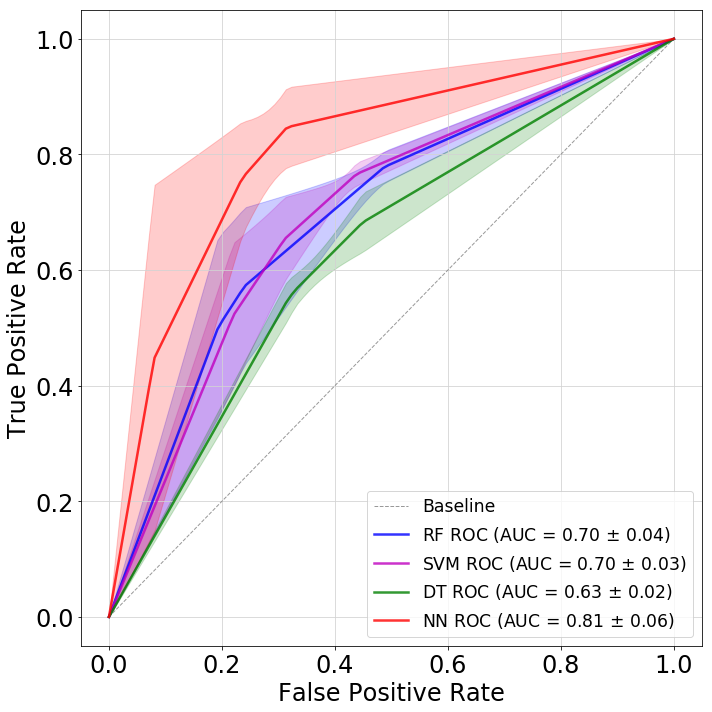

In [27]:

# PLOT THE BASELINE
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',
         label='Baseline', alpha=.8)

mean_cRF_tpr = np.mean(cRF_tprs, axis=0)
mean_cRF_tpr[-1] = 1.0
mean_cRF_auc = auc(mean_fpr, mean_cRF_tpr)
print("Mean AUC {}".format(mean_cRF_auc))
std_cRF_auc = np.std(cRF_aucs)

mean_cSVM_tpr = np.mean(cSVM_tprs, axis=0)
mean_cSVM_tpr[-1] = 1.0
mean_cSVM_auc = auc(mean_fpr, mean_cSVM_tpr)
print("Mean AUC {}".format(mean_cSVM_auc))
std_cSVM_auc = np.std(cSVM_aucs)

mean_cDT_tpr = np.mean(cDT_tprs, axis=0)
mean_cDT_tpr[-1] = 1.0
mean_cDT_auc = auc(mean_fpr, mean_cDT_tpr)
print("Mean AUC {}".format(mean_cDT_auc))
std_cDT_auc = np.std(cDT_aucs)

mean_cSNN_tpr = np.mean(cSNN_tprs, axis=0)
mean_cSNN_tpr[-1] = 1.0
mean_cSNN_auc = auc(mean_fpr, mean_cSNN_tpr)
print("Mean AUC {}".format(mean_cSNN_auc))
std_cSNN_auc = np.std(cSNN_aucs)

# PLOT the mean
plt.plot(mean_fpr, mean_cRF_tpr, color='b',
         label=r'RF ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_cRF_auc, std_cRF_auc),
         lw=2.5, alpha=.8)

std_cRF_tpr = np.std(cRF_tprs, axis=0)
cRF_tprs_upper = np.minimum(mean_cRF_tpr + std_cRF_tpr, 1)
cRF_tprs_lower = np.maximum(mean_cRF_tpr - std_cRF_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cRF_tprs_lower, cRF_tprs_upper, color='b', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cSVM_tpr, color='m',
         label=r'SVM ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_cSVM_auc, std_cSVM_auc),
         lw=2.5, alpha=.8)

std_cSVM_tpr = np.std(cSVM_tprs, axis=0)
cSVM_tprs_upper = np.minimum(mean_cSVM_tpr + std_cSVM_tpr, 1)
cSVM_tprs_lower = np.maximum(mean_cSVM_tpr - std_cSVM_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cSVM_tprs_lower, cSVM_tprs_upper, color='m', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cDT_tpr, color='g',
         label=r'DT ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_cDT_auc, std_cDT_auc),
         lw=2.5, alpha=.8)

std_cDT_tpr = np.std(cDT_tprs, axis=0)
cDT_tprs_upper = np.minimum(mean_cDT_tpr + std_cDT_tpr, 1)
cDT_tprs_lower = np.maximum(mean_cDT_tpr - std_cDT_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cDT_tprs_lower, cDT_tprs_upper, color='g', alpha=.2)#, label=r'$\pm$ 1 std. dev.')


# PLOT the mean
plt.plot(mean_fpr, mean_cSNN_tpr, color='r',
         label=r'NN ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_cSNN_auc, std_cSNN_auc),
         lw=2.5, alpha=.8)

std_cSNN_tpr = np.std(cSNN_tprs, axis=0)
cSNN_tprs_upper = np.minimum(mean_cSNN_tpr + std_cSNN_tpr, 1)
cSNN_tprs_lower = np.maximum(mean_cSNN_tpr - std_cSNN_tpr, 0)

# PLOT
plt.fill_between(mean_fpr, cSNN_tprs_lower, cSNN_tprs_upper, color='r', alpha=.2)#, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('svPPA')
plt.legend(loc="lower right")
plt.grid(color="lightgray")
save_fig("fig",2_1)
plt.show()

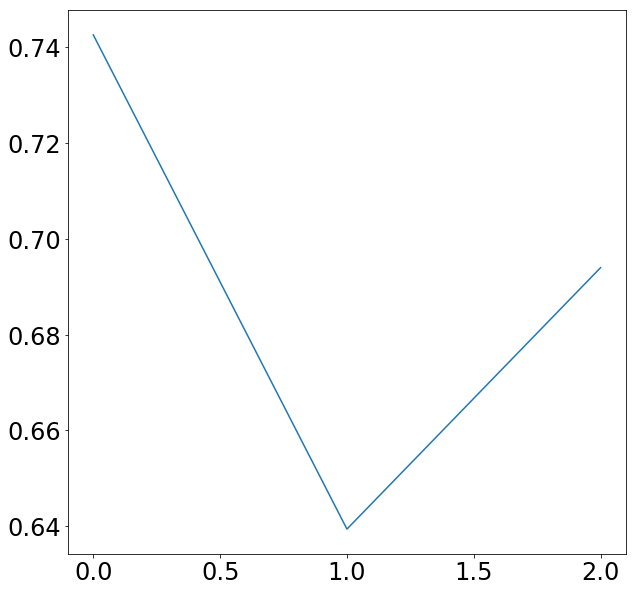

In [28]:
plt.plot(cRF_resultsB)

In [29]:
np.max(cRF_resultsB)

0.7426303854875284

In [30]:
cRF_resultsB.index(np.max(cRF_resultsB))

0

In [31]:
np.max(cSVM_resultsB)

0.7290249433106576

In [32]:
cSVM_resultsB.index(np.max(cSVM_resultsB))

0

In [33]:
np.max(cDT_resultsB)

0.6417370325693607

In [34]:
cDT_resultsB.index(np.max(cDT_resultsB))

1

In [35]:
512/3

170.66666666666666

In [36]:
evaluate_from_history(history)

Epoch:1
 Accuracy: 0.8569379219458881, Loss: 0.28683513978937897
Epoch:2
 Accuracy: 0.9908469631616897, Loss: 0.024731224270751178
Epoch:3
 Accuracy: 0.9956212743691782, Loss: 0.012053711140120868

Total Results:    
Final Accuracy: 0.9478020531589187    
SD Accuracy: 0.06428020051669936    
Final Loss: 0.10787335840008368


In [40]:
cSNN_resultsB

[[1.8613307849079572, 0.7392290252136265],
 [1.8412223477702951, 0.7780458374966759],
 [0.6880294763898275, 0.8975903607276549]]

In [43]:
np.mean([0.7392290252136265, 0.7780458374966759,0.8975903607276549])

0.8049550744793191

In [44]:
np.std([0.74036281138590943, 0.79613992755174345,0.86024096457354993])

0.048979362146755634